In [6]:
%matplotlib inline
# python libraties
import os, cv2,itertools, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

## Step 1: Import Data

We are working with the HAM10000 dataset. The goal is to build a binary classifier to detect benign moles from melanoma. We know the metadata file contains 7 classes. Since some of them are really under-represented in the dataset, we have chosen to bind the class 'Melanocytic nevi' and 'Benign keratosis-like lesion' as the 'benign' class, and the 'melanoma' as the malignant class. 

First, from the original HAM10000_metadata.csv file, we want to extract the one which are from the 3 classes of interests:

In [7]:
df = pd.read_csv("dataset/original/HAM10000_metadata.csv")

# Filter classes of interest
filtered_lesions = ['nv', 'mel', 'bkl']
df = df[df['dx'].isin(filtered_lesions)]

# Creating benign and malignant classes
df['class'] = df['dx'].apply(lambda x: 'benign' if x in ['nv', 'blk'] else 'malignant')

# Saving obtained csv
df.to_csv('dataset/new/filtered_metadata.csv', index=False)

Create a dictionary with key being the ISIC id and the value the path to the image

In [11]:
ids = set(df['image_id'])
dest_dir = 'dataset/new/images/'
data_dir = 'dataset/original' #database directory

# find all files with jpg extension in database directory
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg')) 

# map base filaname to its path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [12]:
def remove_hair(path):
    src = cv2.imread(path)
    grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the 
    # hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # intensify the hair countours in preparation for the inpainting 
    # algorithm
    ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint the original image depending on the mask
    dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA)
    
    return dst

In [14]:
# copy all images from new metadata file and remove hair
for id in tqdm(ids):  
    hair_removed_img = remove_hair(imageid_path_dict[id])
    name = dest_dir + str(id) + ".jpg"
    cv2.imwrite(name, hair_removed_img)

100%|██████████████████████████████████████████████████████████████████████████████| 8917/8917 [34:05<00:00,  4.36it/s]


In [25]:
new_image_path = glob(os.path.join('dataset/new', '*', '*.jpg'))
new_imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in new_image_path}

## Step 2: Data Preprocessing

Compute mean and standard deviation over all images, will be used for normalization

In [30]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [31]:
norm_mean,norm_std = compute_img_mean_std(new_image_path)

100%|█████████████████████████████████████████████████████████████████████████████| 8917/8917 [00:34<00:00, 257.69it/s]


(224, 224, 3, 8917)
normMean = [0.76522636, 0.5432338, 0.56747556]
normStd = [0.1419761, 0.15172158, 0.16932888]


In [32]:
#Add path to image dataframe
df['path'] = df['image_id'].map(new_imageid_path_dict.get)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,class,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,malignant,dataset/new\images\ISIC_0031633.jpg


The next cells are here to extract the images that are unduplicated in the dataset, and creates a validation set from them. This is because we do not want images both in training and validation set.

Note: the validation set is created from 20% of the unduplicated images

In [33]:
# Get how many images are assiocated to each lesion id from HAM dataset
df_undup = df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True) #reset the indexes from the df_undup
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,class,path
0,HAM_0000001,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1


In [34]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(get_duplicates)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,class,path,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0027419.jpg,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0025030.jpg,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0026769.jpg,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0025661.jpg,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,malignant,dataset/new\images\ISIC_0031633.jpg,duplicated


In [35]:
df['duplicates'].value_counts()

unduplicated    5085
duplicated      3832
Name: duplicates, dtype: int64

In [36]:
# now we filter out images that don't have duplicates
df_undup = df[df['duplicates'] == 'unduplicated']

In [37]:
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,class,path,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,malignant,dataset/new\images\ISIC_0025276.jpg,unduplicated
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,malignant,dataset/new\images\ISIC_0031326.jpg,unduplicated
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,malignant,dataset/new\images\ISIC_0032343.jpg,unduplicated
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,malignant,dataset/new\images\ISIC_0024981.jpg,unduplicated
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,malignant,dataset/new\images\ISIC_0027815.jpg,unduplicated


In [38]:
# now we create a validation set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['class']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1017, 10)

In [39]:
df_val["class"].value_counts()

benign       883
malignant    134
Name: class, dtype: int64

In [40]:
y.value_counts()

benign       4415
malignant     670
Name: class, dtype: int64

Now we want to exclude all the rows that we put in the validation set

In [41]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column, and apply the get_val_rows function
df['train_or_val'] = df['image_id']
df['train_or_val'] = df['train_or_val'].apply(get_val_rows)

df_train = df[df['train_or_val'] == 'train'] #keep the train rows

In [42]:
print(len(df_train))
print(len(df_val))

7900
1017


In [43]:
df_train["class"].value_counts()

benign       5822
malignant    2078
Name: class, dtype: int64

In [44]:
df_val["class"].value_counts()

benign       883
malignant    134
Name: class, dtype: int64

### Class imbalance issue
In the training set, malignant image represent approximately 26% of the dataframe, but only 13% from the validation set. This seems might be because we created the validation set from duplicated images only, maybe indicating that there are more duplicateds from benign cancer. This is an issue that we might want to mitigate later. For now, we will apply an augmentation rate of 3, as I think the issue linked to class balancing will mostly presents itself during training.

In [45]:
# Copy fewer class to balance the number of 7 classes
malignant_augmentation_rate = 3
#if rate = 3 => me must add it 3-1 = 2 times

df_train=df_train.append([df_train.loc[df_train['class'] == 'malignant',:]]*(malignant_augmentation_rate-1), ignore_index=True)
df_train['class'].value_counts()

C:\Users\shrey\AppData\Local\Temp\ipykernel_6344\1561135815.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['class'] == 'malignant',:]]*(malignant_augmentation_rate-1), ignore_index=True)


malignant    6234
benign       5822
Name: class, dtype: int64

In [46]:
#At the end, reset the pandas dataframe index
df_train = df_train.reset_index()
df_val = df_val.reset_index()

## Step 3: Model Building

In [47]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [48]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

###### Note: it might be interesting to see how the model behave with feature_extract set to True

In [49]:
# Build the desired model
model_name = 'densenet'
num_classes = 2
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") #on laptop, use cpu torch

# device = torch.device('cuda:0')
print(device)
# Put the model on the device:
model = model_ft.to(device)

C:\Users\shrey\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\shrey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\shrey/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

cpu


In [50]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [51]:
def class_to_int(cls):
    if cls == 'benign':
        return 0
    elif cls == "malignant":
        return 1
    else:
        print("There was smtg weird, return 1 to avoid crashing")
        return 1

In [52]:
index = 0 #3400 is benign
class_to_int(df_train['class'][index])

1

In [53]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(class_to_int(self.df['class'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [54]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
#NOTE: previously set batch_size to 32
train_loader = DataLoader(training_set, batch_size = 32, shuffle=True)
# train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size = 32, shuffle=False)
# val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [55]:
df_val["class"].value_counts()

benign       883
malignant    134
Name: class, dtype: int64

In [56]:
val_loader

In [57]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [58]:
len(train_loader)

377

In [31]:
len(df_train)

12056

## Step 4: Model Training

In [59]:
# Used during training, to compute the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [60]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        #print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [61]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [62]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 377], [train loss 0.53248], [train acc 0.73219]
[epoch 1], [iter 200 / 377], [train loss 0.50615], [train acc 0.75016]
[epoch 1], [iter 300 / 377], [train loss 0.49666], [train acc 0.75438]
------------------------------------------------------------
[epoch 1], [val loss 0.45026], [val acc 0.77543]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.45026], [val acc 0.77543]
*****************************************************
[epoch 2], [iter 100 / 377], [train loss 0.45828], [train acc 0.77375]
[epoch 2], [iter 200 / 377], [train loss 0.45155], [train acc 0.77969]
[epoch 2], [iter 300 / 377], [train loss 0.44843], [train acc 0.78177]
------------------------------------------------------------
[epoch 2], [val loss 0.30209], [val acc 0.87375]
------------------------------------------------------------
*****************************************************
best rec

## Step 5: Model Evaluation

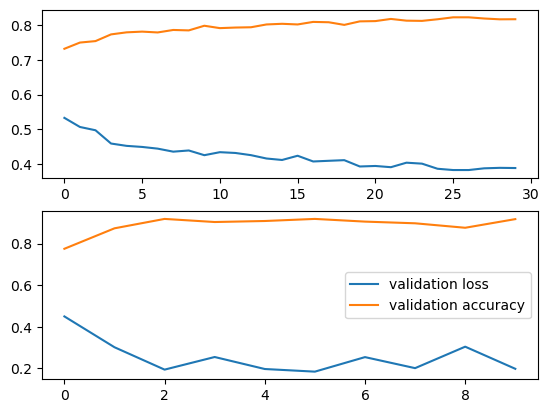

In [67]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [66]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
#         y_predict.extend(prediction.cpu().numpy().T)
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

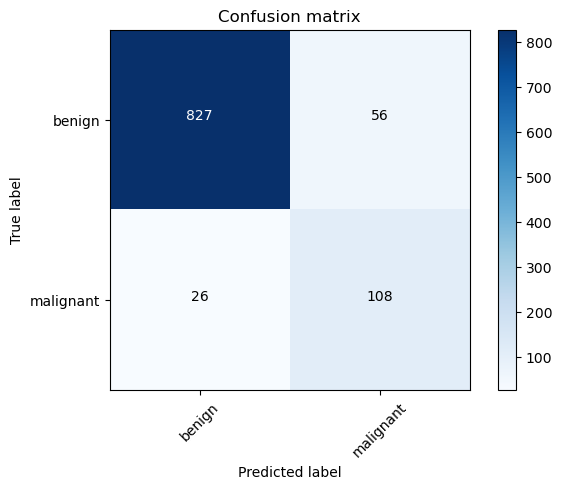

In [68]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['benign', 'malignant']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [69]:
def metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    print("tp, fp, fn, tn", tp, fp, fn, tn)
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    print("correct and total pred", correct_predictions, total_predictions)
    
    accuracy =  correct_predictions / total_predictions
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, F1_score

In [70]:
acc, prec, rec, f1 = metrics(np.array(y_label), np.array(y_predict))
acc
print("Models performance metrics: \n Accuracy: {} \n Precision: {} \n Recall: {} \n F1 score {}".format(acc, prec, rec, f1))

tp, fp, fn, tn 108 56 26 827
correct and total pred 935 1017
Models performance metrics: 
 Accuracy: 0.9193706981317601 
 Precision: 0.6585365853658537 
 Recall: 0.8059701492537313 
 F1 score 0.7248322147651006


## Loading & Saving Model


In [71]:
# Save model
torch.save(model.state_dict(), "models/model2.pt")

In [122]:
#Loading model
model.load_state_dict(torch.load("models/model1.pt"))

<All keys matched successfully>